In [23]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import nltk
from nltk.stem import WordNetLemmatizer
import string
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from transformers import pipeline
from transformers import AutoTokenizer, AutoModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF

In [24]:
df = pd.read_csv('../data/restaurant_data/reviews/merged_dataset.csv')
df.head() # google reviews dataframe
print(df.shape)
print(df.columns)
print(df)


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
unique_categories = df['main_category'].nunique()
print(unique_categories)


146


## Tokenization Pipeline


In [ ]:
df['review_text'] = df['review_text'].fillna('0') # change null into zeroes


In [ ]:
# Check data types
print(df['review_text'].apply(type).value_counts())

# Handle non-string values
df['review_text'] = df['review_text'].astype(str)

<class 'str'>    619630
Name: review_text, dtype: int64


In [ ]:
non_string_rows = df[~df['review_text'].apply(lambda x: isinstance(x, str))]

print("Rows with non-string values:")
print(non_string_rows)


Rows with non-string values:
Empty DataFrame
Columns: [place_id, name, reviews, main_category, main_rating, address, link, review_photos, cuisine, latitude, longtitude, full_postal_code, postal_code, district_code, region, rating, review_text, published_at_date, review_likes_count, response_from_owner_text, total_number_of_reviews_by_reviewer, total_number_of_photos_by_reviewer, is_local_guide]
Index: []

[0 rows x 23 columns]


Lemmarization and StopWord

In [ ]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_review(review):
    if pd.isnull(review):
        return []
    tokens = nltk.word_tokenize(review) #tokenize word
    tokens = [word.lower() for word in tokens if word.isalpha()] #lower str words
    tokens = [word for word in tokens if word not in stop_words] # stop words, remove useless words
    tokens = [lemmatizer.lemmatize(word) for word in tokens] # strip words to basic word
    return tokens

# Apply preprocessing
df['tokenized_reviews'] = df['review_text'].apply(preprocess_review)


[nltk_data] Downloading package punkt to /home/ronaldlin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ronaldlin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ronaldlin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/ronaldlin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df.shape

(619630, 24)

### Text Analysis

  1. Sentiment Analysis
  Purpose: Sentiment analysis is used to determine the emotional tone behind a body of text. This can help in understanding opinions, sentiments, and feelings expressed in the text. 
  2. Frequency Analysis
  Purpose: Frequency analysis involves counting the occurrences of words or phrases in a text corpus. This helps in understanding the most common terms and can be used for various applications like keyword extraction and content summarization.
  3. Topic Modeling
  Purpose: Topic modeling is used to identify themes or topics within a large corpus of text. It helps in discovering the underlying structure and topics present in the data.
  4. Creating Word Clouds
  Purpose: Word clouds are visual representations of word frequency in a text corpus. Words that appear more frequently are displayed more prominently.

Sentiment Analysis : using TextBlob

In [ ]:
# Apply sentiment analysis to each review
df['review_sentiment'] = df['tokenized_reviews'].apply(lambda reviews: [TextBlob(review).sentiment.polarity for review in reviews])

# Calculate average sentiment for each shop
df['average_sentiment'] = df['review_sentiment'].apply(lambda sentiments: sum(sentiments) / len(sentiments) if sentiments else None)

print(df[['name', 'average_sentiment']])





"""The average_sentiment reflects the overall sentiment of the reviews for each shop, based on the sentiment polarity scores provided by TextBlob. Sentiment polarity ranges from -1 to 1:

-1: Very negative sentiment
0: Neutral sentiment
1: Very positive sentiment
Here’s how to interpret the average_sentiment scores based on the range:

Positive Scores (e.g., 0.012500 to 0.095833): These values indicate a generally positive sentiment in the reviews. The higher the score, the more positive the sentiment. For example, an average sentiment of 0.075817 suggests that, on average, the reviews are slightly positive.

NaN Values: These indicate that there were no reviews or sentiment scores available for that shop. NaN stands for "Not a Number" and generally appears when there's missing or incomplete data.

Specific Interpretation of Your Data:

0.046667: Slightly positive sentiment.
NaN: No sentiment data available.
0.095833: Slightly more positive sentiment compared to 0.046667.
0.075817: Positive sentiment, slightly higher than 0.046667.
0.012500: Very mildly positive sentiment.
Overall, these scores suggest that the reviews for the shop are generally positive, but the differences between the scores are relatively small. If you want a more detailed analysis, you could consider additional metrics or more sophisticated sentiment analysis tools.
"""


                                           name  average_sentiment
0             Red House Seafood Grand Copthorne       5.000000e-02
1             Red House Seafood Grand Copthorne       1.448276e-01
2             Red House Seafood Grand Copthorne       4.805556e-02
3             Red House Seafood Grand Copthorne       4.034119e-02
4             Red House Seafood Grand Copthorne       4.107143e-02
...                                         ...                ...
619625  炭香 Charcoal Fish Head Steamboat Kallang       5.551115e-18
619626  炭香 Charcoal Fish Head Steamboat Kallang       8.547009e-02
619627  炭香 Charcoal Fish Head Steamboat Kallang       1.184211e-01
619628  炭香 Charcoal Fish Head Steamboat Kallang       5.357143e-02
619629  炭香 Charcoal Fish Head Steamboat Kallang       9.233333e-02

[619630 rows x 2 columns]


'The average_sentiment reflects the overall sentiment of the reviews for each shop, based on the sentiment polarity scores provided by TextBlob. Sentiment polarity ranges from -1 to 1:\n\n-1: Very negative sentiment\n0: Neutral sentiment\n1: Very positive sentiment\nHere’s how to interpret the average_sentiment scores based on the range:\n\nPositive Scores (e.g., 0.012500 to 0.095833): These values indicate a generally positive sentiment in the reviews. The higher the score, the more positive the sentiment. For example, an average sentiment of 0.075817 suggests that, on average, the reviews are slightly positive.\n\nNaN Values: These indicate that there were no reviews or sentiment scores available for that shop. NaN stands for "Not a Number" and generally appears when there\'s missing or incomplete data.\n\nSpecific Interpretation of Your Data:\n\n0.046667: Slightly positive sentiment.\nNaN: No sentiment data available.\n0.095833: Slightly more positive sentiment compared to 0.046667.

/tmp/ipykernel_2217110/3411921092.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='average_sentiment', y='name', data=sorted_data, palette='viridis')
/home/ronaldlin/.pyenv/versions/3.10.6/envs/yumspeakenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36255 (\N{CJK UNIFIED IDEOGRAPH-8D9F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ronaldlin/.pyenv/versions/3.10.6/envs/yumspeakenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28907 (\N{CJK UNIFIED IDEOGRAPH-70EB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ronaldlin/.pyenv/versions/3.10.6/envs/yumspeakenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 40635 (\N{CJK UNIFIED IDEOGRAPH-9EBB}) missing from fon

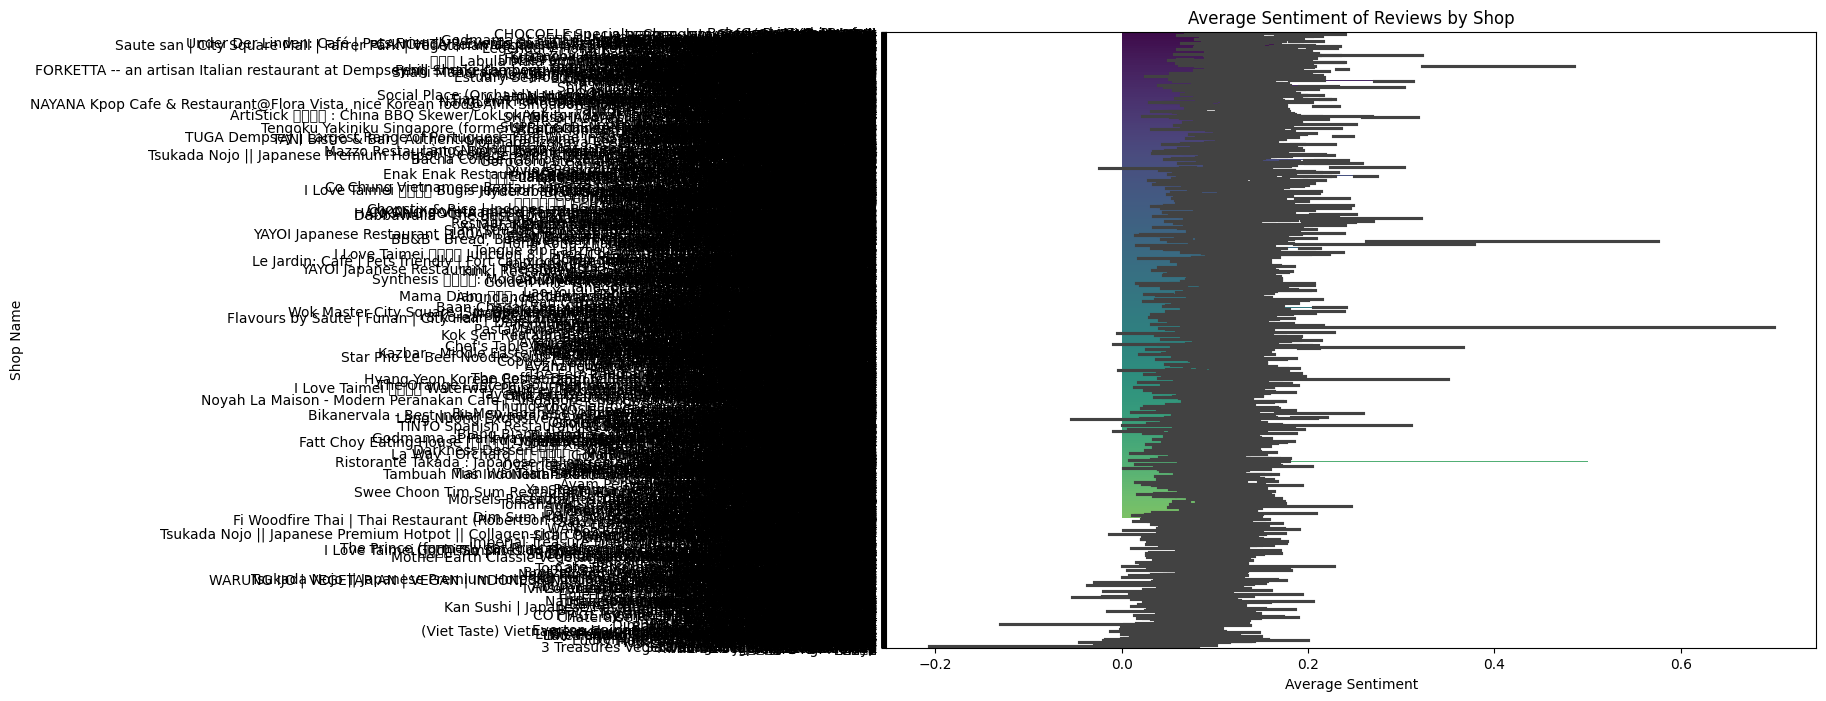

In [ ]:
# Sort data by average sentiment for better visualization
sorted_data = df[['name', 'average_sentiment']].sort_values(by='average_sentiment', ascending=False)

# Plot using seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='average_sentiment', y='name', data=sorted_data, palette='viridis')

# Add labels and title
plt.xlabel('Average Sentiment')
plt.ylabel('Shop Name')
plt.title('Average Sentiment of Reviews by Shop')

# Show the plot
plt.show()

Sentiment Analysis: Using VADER

In [ ]:
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def vader_sentiment(review):
    return sia.polarity_scores(review)['compound']

df['sentiments'] = df['tokenized_reviews'].apply(lambda reviews: [vader_sentiment(review) for review in reviews])
df['vader_average_sentiment'] = df['sentiments'].apply(lambda sentiments: sum(sentiments) / len(sentiments) if sentiments else None)
print(df[['vader_average_sentiment', 'review_text']])

"""Understanding the compound Score:
Range: The compound score ranges from -1 to 1:

-1: Very negative sentiment
0: Neutral sentiment
1: Very positive sentiment
Calculation: The compound score is calculated by summing the valence scores of each word in the text, adjusting for the intensity of the sentiment, and then normalizing the result. The compound score provides an overall measure of sentiment in a single value.

Usefulness: The compound score is useful for getting a quick, overall assessment of sentiment. It is particularly effective for summarizing the sentiment of longer texts, such as reviews, by combining various sentiment scores into a single metric."""

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ronaldlin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


        vader_average_sentiment  \
0                      0.292950   
1                      0.101262   
2                      0.039893   
3                      0.057539   
4                      0.032568   
...                         ...   
619625                 0.012965   
619626                 0.094428   
619627                 0.086168   
619628                 0.044636   
619629                 0.097824   

                                              review_text  
0                                             Food is Wow  
1       I always stay at the Grand Copthorne Waterfron...  
2       My family and I had a gathering at Red House S...  
3       Celebrated my MIL 70th birthday and pre-coordi...  
4       Had a wonderful dinner here tonight. The highl...  
...                                                   ...  
619625  Almost 2 hours waiting time, order taken at 6....  
619626  2nd time trying the fish head steamboat. Its t...  
619627  The food here is most excellent

'Understanding the compound Score:\nRange: The compound score ranges from -1 to 1:\n\n-1: Very negative sentiment\n0: Neutral sentiment\n1: Very positive sentiment\nCalculation: The compound score is calculated by summing the valence scores of each word in the text, adjusting for the intensity of the sentiment, and then normalizing the result. The compound score provides an overall measure of sentiment in a single value.\n\nUsefulness: The compound score is useful for getting a quick, overall assessment of sentiment. It is particularly effective for summarizing the sentiment of longer texts, such as reviews, by combining various sentiment scores into a single metric.'

/tmp/ipykernel_2217110/1196329585.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='average_sentiment', y='name', data=sorted_shops, palette='coolwarm')
/home/ronaldlin/.pyenv/versions/3.10.6/envs/yumspeakenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36255 (\N{CJK UNIFIED IDEOGRAPH-8D9F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ronaldlin/.pyenv/versions/3.10.6/envs/yumspeakenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28907 (\N{CJK UNIFIED IDEOGRAPH-70EB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ronaldlin/.pyenv/versions/3.10.6/envs/yumspeakenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 40635 (\N{CJK UNIFIED IDEOGRAPH-9EBB}) missing from f

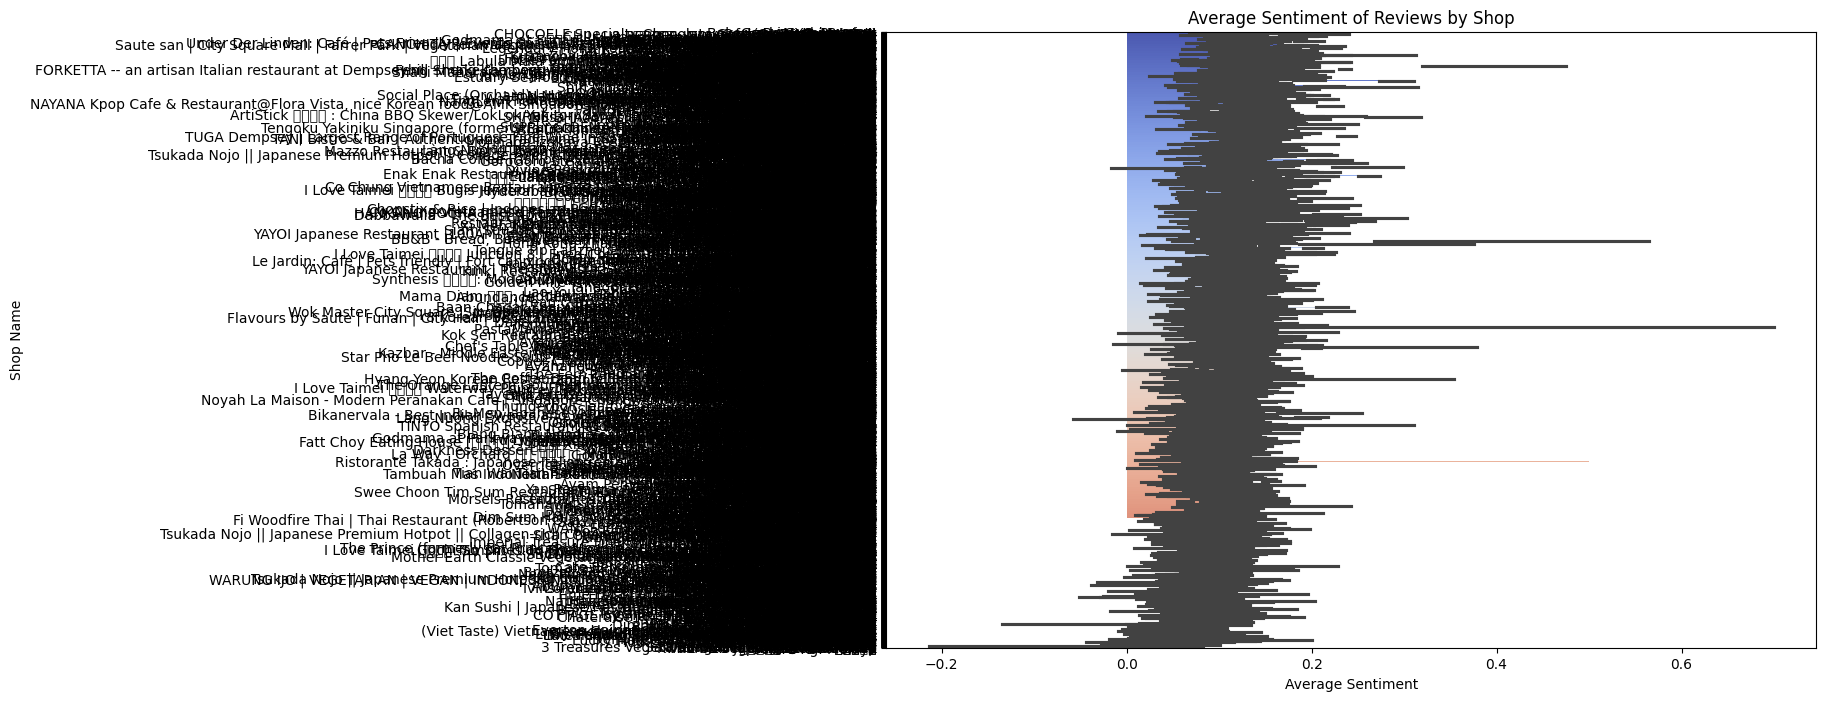

In [ ]:
# Sort DataFrame by average sentiment for better visualization
sorted_shops = df[['name', 'average_sentiment']].sort_values(by='average_sentiment', ascending=False)

# Plot using seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='average_sentiment', y='name', data=sorted_shops, palette='coolwarm')

# Add labels and title
plt.xlabel('Average Sentiment')
plt.ylabel('Shop Name')
plt.title('Average Sentiment of Reviews by Shop')

# Show the plot
plt.show()


Frequency Analysis

In [ ]:
# Assuming tokenized_reviews is a list of lists where each inner list is a list of tokens
# Flatten the list of lists into a single list of tokens
all_tokens = [token for sublist in df['tokenized_reviews'] for token in sublist]

# Count word frequencies
frequency = Counter(all_tokens)

# Print word frequencies
print(frequency)


Counter({'food': 409387, 'good': 250260, 'service': 217893, 'great': 138696, 'staff': 117859, 'nice': 111175, 'place': 108840, 'restaurant': 87181, 'dish': 85402, 'delicious': 78957, 'time': 78813, 'friendly': 73533, 'really': 72760, 'u': 66793, 'taste': 65631, 'also': 61562, 'experience': 61168, 'like': 60717, 'one': 57644, 'back': 56469, 'come': 54722, 'price': 53674, 'well': 52228, 'chicken': 51023, 'try': 48533, 'would': 47404, 'ordered': 46573, 'best': 45430, 'definitely': 43765, 'order': 42673, 'love': 41668, 'recommend': 40323, 'rice': 39999, 'option': 39534, 'excellent': 39499, 'vegetarian': 38559, 'amazing': 38361, 'soup': 38267, 'menu': 38042, 'even': 37634, 'table': 37008, 'meal': 35165, 'portion': 34608, 'beef': 34420, 'coffee': 34088, 'drink': 33778, 'lunch': 33393, 'fresh': 33117, 'pork': 33115, 'served': 33013, 'quite': 32975, 'came': 32498, 'go': 31998, 'quality': 31938, 'meat': 31056, 'fried': 30789, 'dinner': 30730, 'get': 30542, 'ambience': 30218, 'singapore': 29584,

Word Frequency In Reviews

/tmp/ipykernel_2217110/3287566628.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=top_words, palette='viridis')


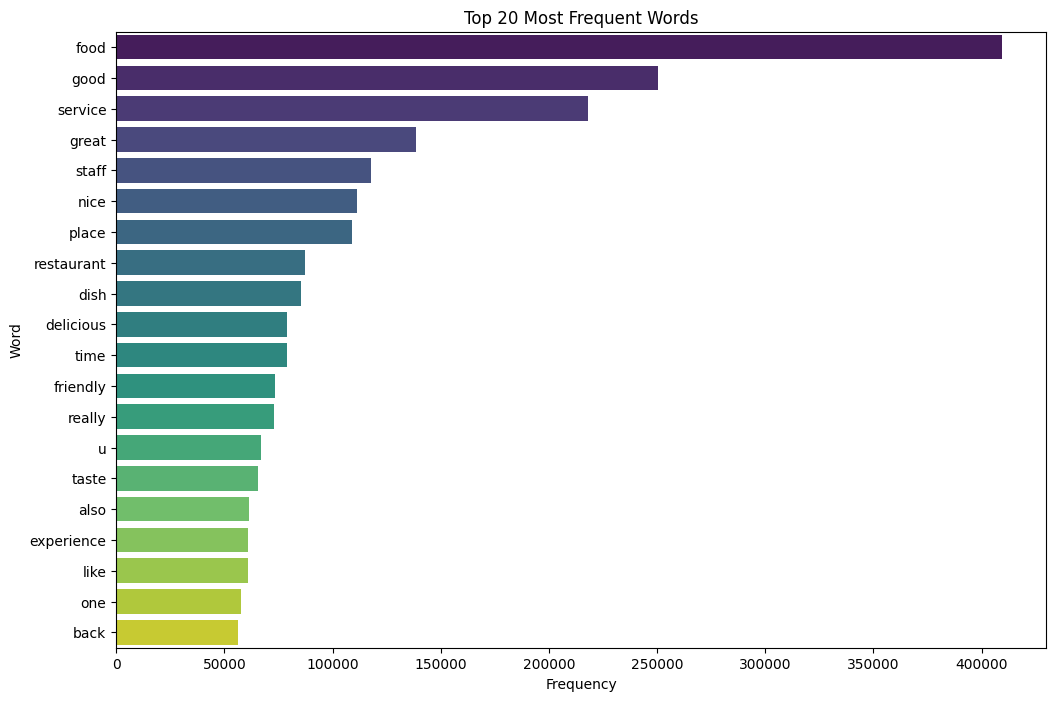

In [ ]:
# Assuming `frequency` is the Counter object from the previous code
# Convert the Counter object to a DataFrame for easier plotting
frequency_df = pd.DataFrame(frequency.items(), columns=['Word', 'Frequency'])

# Sort the DataFrame by frequency in descending order
frequency_df = frequency_df.sort_values(by='Frequency', ascending=False)

# Limit the number of words to plot (e.g., top 20 words)
top_words = frequency_df.head(20)

# Plot using seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Word', data=top_words, palette='viridis')

# Add labels and title
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 20 Most Frequent Words')

# Show the plot
plt.show()

# These are the words that we can be considered for use in modeling or other variables

Word Cloud

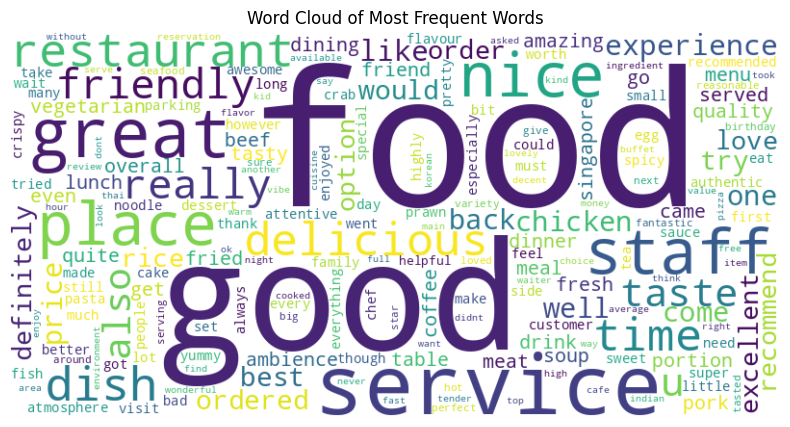

In [ ]:
# Convert the Counter object to a dictionary for WordCloud
word_freq = dict(frequency)

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(word_freq)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('Word Cloud of Most Frequent Words')
plt.show()

Distribution Analysis

In [ ]:
sentences = df['review_text'] #sentence length
sentence_lengths = [len(sentence.split()) for sentence in sentences]
print(sentence_lengths)

tokens = df['tokenized_reviews'] #word length
word_lengths = [len(word) for word in tokens]
print(word_lengths)


[3, 61, 60, 176, 49, 10, 2, 4, 20, 32, 76, 42, 43, 21, 33, 31, 53, 4, 60, 8, 127, 103, 263, 92, 43, 94, 10, 3, 172, 35, 46, 22, 72, 23, 3, 91, 104, 40, 23, 20, 36, 22, 6, 8, 10, 6, 13, 19, 19, 33, 4, 7, 63, 31, 23, 9, 12, 5, 8, 6, 6, 5, 15, 8, 5, 5, 4, 31, 22, 2, 4, 6, 23, 17, 5, 14, 8, 16, 7, 9, 49, 5, 48, 25, 7, 43, 17, 55, 17, 26, 99, 8, 10, 10, 9, 4, 229, 47, 85, 1, 137, 3, 44, 152, 16, 56, 4, 28, 12, 10, 37, 116, 24, 29, 5, 38, 5, 83, 55, 50, 40, 29, 37, 152, 10, 52, 9, 15, 37, 22, 30, 97, 10, 114, 23, 7, 43, 58, 3, 51, 16, 14, 5, 12, 91, 37, 19, 18, 47, 15, 163, 65, 92, 4, 107, 51, 68, 29, 88, 150, 10, 28, 10, 167, 3, 22, 9, 17, 6, 20, 60, 18, 25, 86, 13, 25, 14, 45, 18, 40, 28, 7, 16, 97, 17, 8, 49, 29, 70, 25, 51, 103, 45, 9, 65, 39, 6, 40, 10, 4, 18, 19, 10, 29, 14, 166, 72, 18, 6, 37, 25, 4, 47, 9, 8, 34, 9, 20, 22, 2, 11, 5, 6, 2, 8, 2, 45, 4, 15, 38, 32, 5, 5, 9, 4, 13, 18, 6, 5, 4, 12, 111, 36, 247, 1, 11, 43, 10, 46, 169, 21, 155, 32, 18, 14, 82, 8, 59, 26, 34, 20, 22, 16

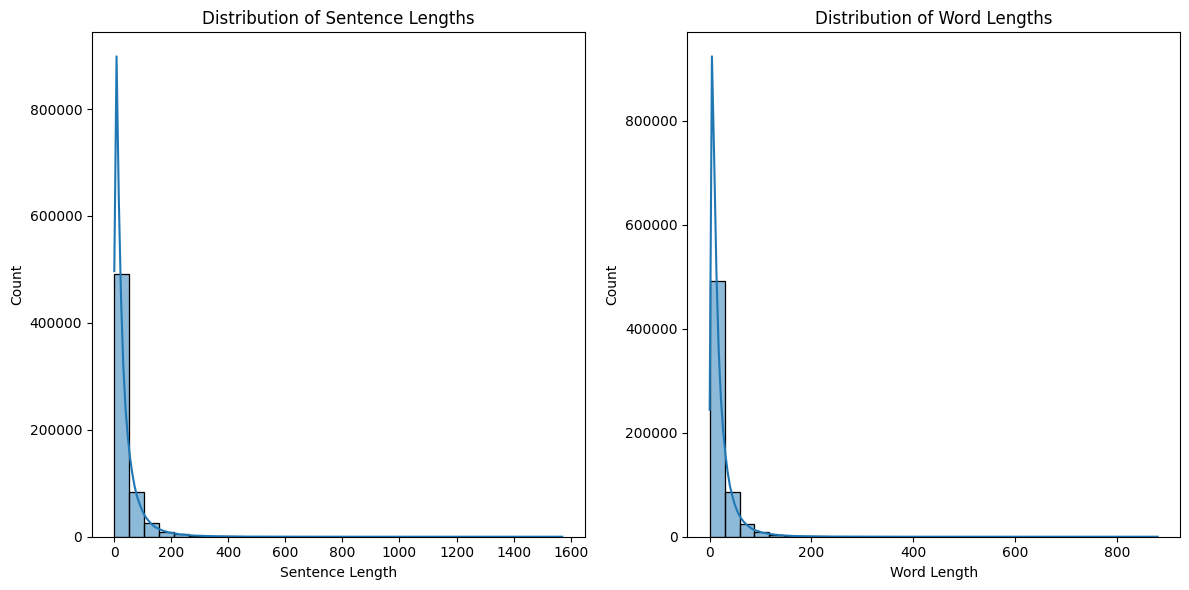

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(sentence_lengths, bins=30, kde=True)
plt.xlabel('Sentence Length')
plt.title('Distribution of Sentence Lengths')

plt.subplot(1, 2, 2)
sns.histplot(word_lengths, bins=30, kde=True)
plt.xlabel('Word Length')
plt.title('Distribution of Word Lengths')

plt.tight_layout()
plt.show()


N-Gram Analysis

In [ ]:
tokens = df['tokenized_reviews']
vectorizer = CountVectorizer(ngram_range=(2, 2))  # Bigrams
X = vectorizer.fit_transform([' '.join(review) for review in tokens])
bigrams = vectorizer.get_feature_names_out()
bigram_counts = X.sum(axis=0).A1

# Construct the bigram dictionary with counts
bigram_dict = {}
for bigram, count in zip(bigrams, bigram_counts):
    bigram_tuple = tuple(bigram.split())  # Convert bigram string to tuple
    bigram_dict[bigram_tuple] = count

# Now assign sentiment scores manually or based on some logic
sentiment_dict = {}
for bigram, count in bigram_dict.items():
    if bigram in [("don't", "like"), ("is", "terrible")]:  # Example negative bigrams
        sentiment_dict[bigram] = -count  # Assign negative score
    elif bigram in [("like", "this"), ("this", "movie")]:  # Example positive/neutral bigrams
        sentiment_dict[bigram] = count  # Assign positive/neutral score
    else:
        sentiment_dict[bigram] = 0  # Neutral if not found in any category

# Calculate the overall sentiment score
sentiment_score = sum(sentiment_dict.get(bigram, 0) for bigram in bigram_dict.keys())

print(sentiment_score)

# sentiment_score = 0
# for bigram in bigram_dict.keys():
#     bigram_tuple = tuple(bigram.split())  # Ensure format matches sentiment_dict
#     score = sentiment_dict.get(bigram_tuple, 0)  # Retrieve sentiment score
#     sentiment_score += score * bigram_dict[bigram]  # Multiply by count
#     print(f"Bigram: {bigram_tuple}, Count: {bigram_dict[bigram]}, Score: {score}")

# print(f"Total Sentiment Score: {sentiment_score}")

'''sentiment_score will always return 0 as no words are being keyed into either sentiment_dict.
As such, N-Gram is not suitable for model, as we have to manually key in all the words for each sentiment.
As such, I recommend the next best model, BERT'''

0


'sentiment_score will always return 0 as no words are being keyed into either sentiment_dict.\nAs such, N-Gram is not suitable for model, as we have to manually key in all the words for each sentiment. \nAs such, I recommend the next best model, BERT'

Most Common Bigrams

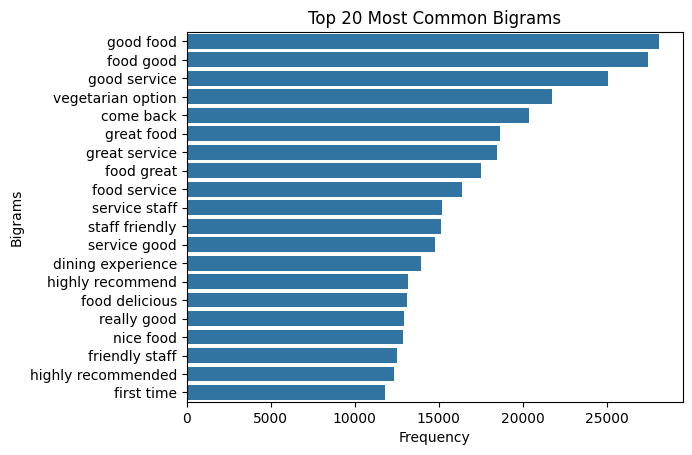

In [ ]:
bigram_counts_dict = dict(zip(bigrams, bigram_counts))
common_bigrams = Counter(bigram_counts_dict).most_common(20)
bigrams, counts = zip(*common_bigrams)
sns.barplot(x=counts, y=bigrams)
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.title('Top 20 Most Common Bigrams')
plt.show()

This graph shows that most sentiments are generally positive

BERT model analysis

In [ ]:
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Convert tokenized reviews to strings
reviews = [' '.join(review) for review in df['tokenized_reviews']]

# # BERT Model only can run 512 rows max
subset = reviews[:512]

# Analyze sentiment of the small subset
results = sentiment_pipeline(subset)

# Analyze sentiment of the data
# results = sentiment_pipeline(reviews)


# Display results
for review, result in zip(subset, results):
    print(f"Review: {review}")
    print(f"Sentiment: {result['label']} with score: {result['score']}")
    print()


# sentiment_scores = []
# for review in data['tokenized_reviews']:
#     # Join tokens to form the original review text
#     review_text = ' '.join(review)
#     result = sentiment_model(review_text)
#     sentiment_scores.append(result)

'''Bert sentiment streamlines the key word search to a higher precision with sentiment analysis'''


/home/ronaldlin/.pyenv/versions/3.10.6/envs/yumspeakenv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Review: food wow
Sentiment: POSITIVE with score: 0.9997265934944153

Review: always stay grand copthorne waterfront hotel first time using restaurant second floor exactly luxurious clean food delicious im satisfied enjoyed chili crab black pepper crab night steamed shrimp delicious
Sentiment: POSITIVE with score: 0.9994383454322815

Review: family gathering red house seafood absolutely bowled great service rendered u staff extremely attentive need older folk even went way custom prepare birthday dessert one family member celebrating birthday day
Sentiment: POSITIVE with score: 0.998602569103241

Review: celebrated mil birthday restaurant special menu also asked special jelly longevity cake arrived restaurant beforehand crew mei yee candy christina extremely accommodating request made day especially special one mom law fam thank u meal attentive cleared plate quickly whilst mindful elderly toddler around table also remembered request surprise cake presented spoil mil surprise food excel

'Bert sentiment streamlines the key word search to a higher precision with sentiment analysis'

In [25]:
df

place_id                                     name  \
0       ChIJYR6HCJ4Z2jERChIQxjl2MhI        Red House Seafood Grand Copthorne   
1       ChIJYR6HCJ4Z2jERChIQxjl2MhI        Red House Seafood Grand Copthorne   
2       ChIJYR6HCJ4Z2jERChIQxjl2MhI        Red House Seafood Grand Copthorne   
3       ChIJYR6HCJ4Z2jERChIQxjl2MhI        Red House Seafood Grand Copthorne   
4       ChIJYR6HCJ4Z2jERChIQxjl2MhI        Red House Seafood Grand Copthorne   
...                             ...                                      ...   
619625  ChIJ0T6YJPkZ2jER4SLNFf4Zthg  炭香 Charcoal Fish Head Steamboat Kallang   
619626  ChIJ0T6YJPkZ2jER4SLNFf4Zthg  炭香 Charcoal Fish Head Steamboat Kallang   
619627  ChIJ0T6YJPkZ2jER4SLNFf4Zthg  炭香 Charcoal Fish Head Steamboat Kallang   
619628  ChIJ0T6YJPkZ2jER4SLNFf4Zthg  炭香 Charcoal Fish Head Steamboat Kallang   
619629  ChIJ0T6YJPkZ2jER4SLNFf4Zthg  炭香 Charcoal Fish Head Steamboat Kallang   

        reviews main_category  main_rating  \
0          1110       Seafood          4.2   
1          1110       Seafood          4.2   
2          1110       Seafood          4.2   
3          1110       Seafood          4.2   
4          1110       Seafood          4.2   
...         ...           ...          ...   
619625      490       Chinese          4.1   
619626      490       Chinese          4.1   
619627      490       Chinese          4.1   
619628      490       Chinese          4.1   
619629      490       Chinese          4.1   

                                                  address  \
0       392 Havelock Rd, Level 2 Grand Copthorne Water...   
1       392 Havelock Rd, Level 2 Grand Copthorne Water...   
2       392 Havelock Rd, Level 2 Grand Copthorne Water...   
3       392 Havelock Rd, Level 2 Grand Copthorne Water...   
4       392 Havelock Rd, Level 2 Grand Copthorne Water...   
...                                                   ...   
619625                     5 Kallang Pl, Singapore 339152   
619626                     5 Kallang Pl, Singapore 339152   
619627                     5 Kallang Pl, Singapore 339152   
619628                     5 Kallang Pl, Singapore 339152   
619629                     5 Kallang Pl, Singapore 339152   

                                                     link  \
0       https://www.google.com/maps/place/Red+House+Se...   
1       https://www.google.com/maps/place/Red+House+Se...   
2       https://www.google.com/maps/place/Red+House+Se...   
3       https://www.google.com/maps/place/Red+House+Se...   
4       https://www.google.com/maps/place/Red+House+Se...   
...                                                   ...   
619625  https://www.google.com/maps/place/%E7%82%AD%E9...   
619626  https://www.google.com/maps/place/%E7%82%AD%E9...   
619627  https://www.google.com/maps/place/%E7%82%AD%E9...   
619628  https://www.google.com/maps/place/%E7%82%AD%E9...   
619629  https://www.google.com/maps/place/%E7%82%AD%E9...   

                                            review_photos  cuisine  latitude  \
0       ['https://lh5.googleusercontent.com/p/AF1QipNp...  Seafood  1.290369   
1       ['https://lh5.googleusercontent.com/p/AF1QipNp...  Seafood  1.290369   
2       ['https://lh5.googleusercontent.com/p/AF1QipNp...  Seafood  1.290369   
3       ['https://lh5.googleusercontent.com/p/AF1QipNp...  Seafood  1.290369   
4       ['https://lh5.googleusercontent.com/p/AF1QipNp...  Seafood  1.290369   
...                                                   ...      ...       ...   
619625  ['https://lh5.googleusercontent.com/p/AF1QipM_...  Chinese  1.317298   
619626  ['https://lh5.googleusercontent.com/p/AF1QipM_...  Chinese  1.317298   
619627  ['https://lh5.googleusercontent.com/p/AF1QipM_...  Chinese  1.317298   
619628  ['https://lh5.googleusercontent.com/p/AF1QipM_...  Chinese  1.317298   
619629  ['https://lh5.googleusercontent.com/p/AF1QipM_...  Chinese  1.317298   

        ...  review_likes_count  response_from_owner_text  \
0       ...              

In [ ]:
# data

TF-IDF

In [26]:
# data to run on pre-tokenized texts
corpus = df['review_text']

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=100)

# Fit and transform the corpus
tfidf_matrix = vectorizer.fit_transform(corpus)

# # Convert to DataFrame for easy viewing
# tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
# Reduce dimensionality with Truncated SVD
svd = TruncatedSVD(n_components=50)
reduced_tfidf_matrix = svd.fit_transform(tfidf_matrix)

print(reduced_tfidf_matrix)


[[ 0.33542043  0.33277074 -0.08056913 ... -0.01590908  0.01073227
   0.00498677]
 [ 0.61273215 -0.19847898 -0.03373455 ... -0.0805345  -0.00881402
  -0.01455947]
 [ 0.55600429 -0.2020925   0.18316371 ...  0.0358658   0.15158858
  -0.024936  ]
 ...
 [ 0.52907981  0.02835904 -0.07632939 ... -0.03874919  0.05261988
  -0.04092957]
 [ 0.48811952 -0.05720625  0.2401394  ...  0.0832234  -0.02989132
   0.22564683]
 [ 0.50811321 -0.01499512 -0.14603588 ... -0.10294162 -0.07414905
   0.00245263]]


Query Representation Matrix
TF-IDF with Words2Vec

In [27]:
# Assuming 'data' contains your dataset
# corpus = data['tokenized_reviews']

# Step 1: Tokenize the corpus (assuming already pre-tokenized, else use nltk or similar libraries)
tokenized_corpus = df['tokenized_reviews']

# Step 2: Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)

# Step 3: Convert reviews to Word2Vec vectors (by averaging word vectors)
def get_word2vec_vector(review, model):
    # For each word in the review, get the Word2Vec vector and take the average
    vectors = [model.wv[word] for word in review if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

word2vec_vectors = np.array([get_word2vec_vector(review, word2vec_model) for review in tokenized_corpus])

# Step 4: Reduce dimensionality with Truncated SVD if needed
# Since Word2Vec vectors are already reduced, this step might not be necessary,
# but let's do it for consistency with TF-IDF.
svd_word2vec = TruncatedSVD(n_components=50)
reduced_word2vec_matrix = svd_word2vec.fit_transform(word2vec_vectors)


# Combine the reduced TF-IDF matrix and the reduced Word2Vec matrix
combined_matrix = np.hstack((reduced_tfidf_matrix, reduced_word2vec_matrix))

# If you want to reduce the combined matrix further, apply another SVD
final_svd = TruncatedSVD(n_components=50)  # Adjust n_components based on your needs
final_combined_matrix = final_svd.fit_transform(combined_matrix)

final_combined_matrix


: 

In [ ]:
# Access the components from the final SVD model
svd_components = final_svd.components_

# Get feature names from TF-IDF vectorizer
tfidf_feature_names = vectorizer.get_feature_names_out()

# Get the word vectors from Word2Vec
word2vec_feature_names = [f'word2vec_{i}' for i in range(word2vec_model.vector_size)]

# Combine all feature names
combined_feature_names = np.hstack((tfidf_feature_names, word2vec_feature_names))

n_top_words = 10  # Adjust based on your needs
topics = {}

for topic_idx, component in enumerate(svd_components):
    top_feature_indices = component.argsort()[-n_top_words:]
    top_features = [combined_feature_names[i] for i in top_feature_indices]
    topics[f'Topic {topic_idx}'] = top_features
    print(f"Topic {topic_idx}: {' '.join(top_features)}")

Search TF-IDF/Words2Vec Algorithum

In [ ]:
# # Function to preprocess and convert query
# def preprocess_query(query, tfidf_vectorizer, word2vec_model, svd):
#     # Compute TF-IDF representation
#     tfidf_vector = tfidf_vectorizer.transform([query])
#     tfidf_reduced = svd.transform(tfidf_vector)

#     # Compute Word2Vec representation
#     tokens = query.split()  # Simple tokenization
#     vectors = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
#     word2vec_vector = np.mean(vectors, axis=0) if vectors else np.zeros(word2vec_model.vector_size)
#     word2vec_reduced = svd.transform(word2vec_vector.reshape(1, -1))

#     # Combine both representations
#     combined_query_vector = np.hstack((tfidf_reduced, word2vec_reduced))

#     return combined_query_vector

# # Sample search query
# query = "example search texttttttttttt"

# # Preprocess query and get combined vector
# query_vector = preprocess_query(query, vectorizer, word2vec_model, final_svd)

# # Compute similarity between query vector and document vectors
# similarities = cosine_similarity(query_vector, final_combined_matrix)

# # Get the indices of the most similar documents
# top_indices = np.argsort(similarities[0])[::-1]  # Sorting in descending order

# # Display the top results
# for index in top_indices[:10]:  # Show top 10 results
#     print(f"Document ID: {index}, Similarity Score: {similarities[0][index]}")

Dimensionality Reduction with LSA LSA (Latent Semantic Analysis) and
Topic Modeling with LDA (Latent Dirichlet Allocation)

In [ ]:
# Corpus
corpus = df['review_text']

# Step 1: Count Vectorization
vectorizer = CountVectorizer(max_features=100)  # Adjust max_features as needed
count_matrix = vectorizer.fit_transform(corpus)

# Step 2: Dimensionality Reduction with NMF
# nmf = NMF(n_components=100, random_state=42)  # Reduce to 100 dimensions
# nmf_matrix = nmf.fit_transform(count_matrix)

# Step 2: Dimensionality Reduction with LSA (Truncated SVD)
lsa = TruncatedSVD(n_components=100)  # Reduce to 100 dimensions
lsa_matrix = lsa.fit_transform(count_matrix)

# Optionally ensure non-negative values for LDA
lsa_matrix = np.maximum(lsa_matrix, 0)

# Step 3: Topic Modeling with LDA
lda = LatentDirichletAllocation(n_components=3, random_state=42)  # Find 3 topics
lda_matrix = lda.fit_transform(lsa_matrix)

# Display the topics found by LDA
terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}:")
    print(" ".join([terms[i] for i in topic.argsort()[-10:]]))

# Display the document-topic matrix
print("Document-Topic Matrix:")
print(lda_matrix)

Topic 0:
good but by are be an beef ambience amazing again
Topic 1:
amazing back ambience as an are and all also again
Topic 2:
beef also even by experience came back best at again
Document-Topic Matrix:
[[0.04706459 0.0443636  0.90857181]
 [0.33333333 0.33333333 0.33333333]
 [0.21806143 0.25723464 0.52470392]
 ...
 [0.76707066 0.19680524 0.03612409]
 [0.52973766 0.20857014 0.2616922 ]
 [0.03851274 0.92183291 0.03965435]]
